# Import required libraries

In [3]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import itertools


# Data Preprocessing

In [4]:
# Define batch size and image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Mount Google Drive and set data paths
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Function to load paths and labels
def load_paths_labels(directory, set_name):
    filepaths, labels = [], []
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                filepaths.append(os.path.join(folder_path, file))
                labels.append(folder)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels, 'set': set_name})

# Load data
train_df = load_paths_labels(train_dir, 'train')
val_df = load_paths_labels(val_dir, 'val')
test_df = load_paths_labels(test_dir, 'test')


Mounted at /content/drive


# Data Generators

In [5]:
tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(val_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=False, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                      target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 4740 validated image filenames belonging to 2 classes.
Found 492 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


# Show sample from train data

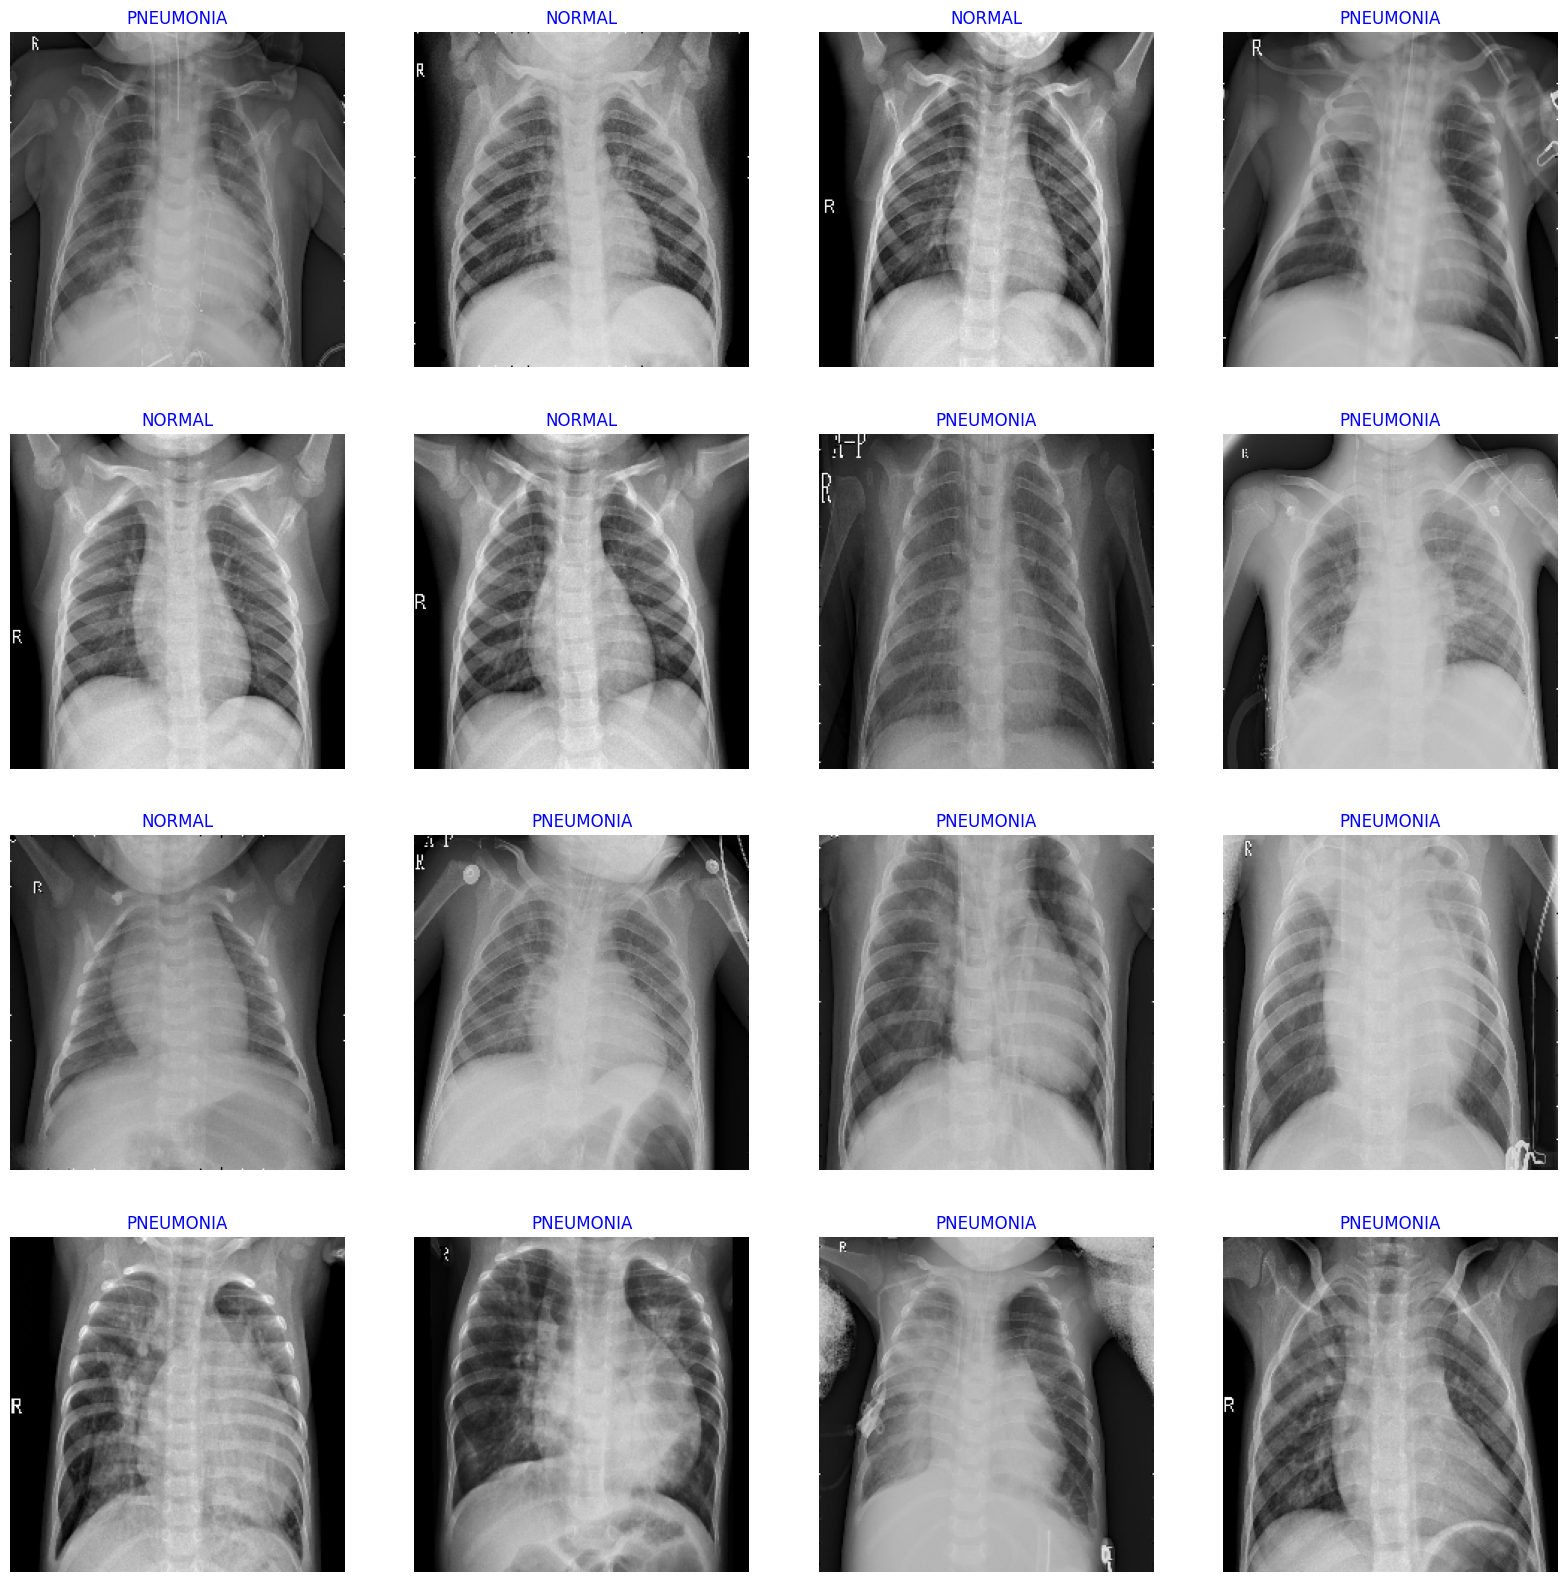

In [6]:
# Visualize a batch of images from the training generator
g_dict = train_gen.class_indices  # Defines dictionary {'class': index}
classes = list(g_dict.keys())     # Defines list of class names

# Retrieve a batch of images and labels from the generator
images, labels = next(train_gen)  # Get a batch of images and corresponding labels

# Plot the images
plt.figure(figsize=(20, 20))
for i in range(16):  # Display first 16 images
    plt.subplot(4, 4, i + 1)
    image = images[i]  # Image is already rescaled if rescale=1./255 is used in ImageDataGenerator
    plt.imshow(image)
    index = np.argmax(labels[i])  # Find the class index from the one-hot encoded labels
    class_name = classes[index]   # Map the index to the class name
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

# Build the MobileNet model

In [7]:
base_model = MobileNet(input_shape=img_shape, include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_gen.class_indices), activation='softmax')  # Fixed the issue here
])

model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,495,874 (13.34 MB)

 Trainable params: 264,962 (1.01 MB)

 Non-trainable params: 3,230,912 (12.32 MB)

# Train the model

In [8]:
start_time = time.time()
history = model.fit(train_gen, validation_data=valid_gen, epochs=10)
training_time = time.time() - start_time
print(f"Training completed in: {training_time:.2f} seconds")

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


297/297 ━━━━━━━━━━━━━━━━━━━━ 1234s 4s/step - accuracy: 0.8720 - loss: 0.3318 - val_accuracy: 0.9634 - val_loss: 0.0775
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 55s 181ms/step - accuracy: 0.9594 - loss: 0.1036 - val_accuracy: 0.9736 - val_loss: 0.0600
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 54s 179ms/step - accuracy: 0.9716 - loss: 0.0765 - val_accuracy: 0.9817 - val_loss: 0.0437
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 55s 180ms/step - accuracy: 0.9788 - loss: 0.0562 - val_accuracy: 0.9776 - val_loss: 0.0520
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 54s 179ms/step - accuracy: 0.9804 - loss: 0.0476 - val_accuracy: 0.9756 - val_loss: 0.0578
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 54s 180ms/step - accuracy: 0.9824 - loss: 0.0429 - val_accuracy: 0.9797 - val_loss: 0.0503
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 54s 179ms/step - accuracy: 0.9875 - loss: 0.0373 - val_accuracy: 0.9858 - val_loss: 0.0421
Epoch 8/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 54s 179ms/step - accuracy: 0.9839 - loss: 0.0392 - val_

# Evaluate the model

39/39 ━━━━━━━━━━━━━━━━━━━━ 454s 12s/step - accuracy: 0.6756 - loss: 1.3877
Test Accuracy: 80.77%
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step
              precision    recall  f1-score   support

      NORMAL       0.98      0.50      0.66       234
   PNEUMONIA       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.87      0.75      0.76       624
weighted avg       0.85      0.81      0.79       624



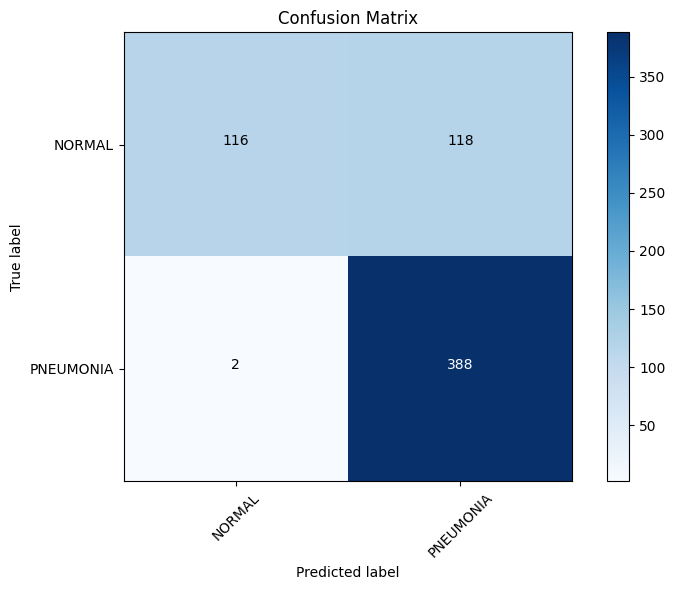

In [9]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy:.2%}")

# Confusion matrix and classification report
y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
report = classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys())

print(report)

# Plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(cm, list(test_gen.class_indices.keys()))
plt.show()


# Display model performance

In [ ]:
import matplotlib.pyplot as plt

# Extracting metrics from history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(12, 5))

# Left plot: Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss', color='blue')
plt.plot(epochs, validation_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Right plot: Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
from sklearn.metrics import classification_report

# Convert predicted probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the classification report
print(classification_report(test_gen.classes, y_pred_classes, target_names=classes))


              precision    recall  f1-score   support

      NORMAL       0.98      0.50      0.66       234
   PNEUMONIA       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.87      0.75      0.76       624
weighted avg       0.85      0.81      0.79       624

